# An Exploration of Covid-19 in Malaysia

The following datasets will be used:
1. cases_malaysia.csv
2. cases_state.csv
3. clusters.csv
4. deaths_malaysia.csv
5. deaths_state.csv
6. hospital.csv
7. icu.csv
8. pkrc.csv
9. tests_malaysia.csv
10. tests_state.csv

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
working_directory = '/content/drive/MyDrive/Data Mining Ass./Assignment part 2/assig-2'
os.chdir(working_directory)

In [ ]:
cases_malaysia = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('./cases/epidemic/cases_state.csv')
clusters = pd.read_csv('./cases/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('./cases/epidemic/deaths_state.csv')
hospital = pd.read_csv('./cases/epidemic/hospital.csv')
icu = pd.read_csv('./cases/epidemic/icu.csv')
pkrc = pd.read_csv('./cases/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('./cases/epidemic/tests_state.csv') 
vax_malaysia = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
vaxreg_malaysia = pd.read_csv('./vaccination/registration/vaxreg_malaysia.csv') 
vaxreg_state = pd.read_csv('./vaccination/registration/vaxreg_state.csv') 
population = pd.read_csv('./vaccination/static/population.csv') 

## EDA and Pre-processing
1. Restructure dataset format by melting/pivot table
2. Deal with missing values and outliers (missing values will be dropped and outliers will be checked on case-by-case basis)

### Cases Malaysia

In [ ]:
cases_malaysia

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,5624.0,1007.0,0.0,0.0,199.0,30.0,10.0,3.0,377.0
620,2021-10-06,9380,13,13045,131981,426.0,1044.0,5338.0,1656.0,752.0,5877.0,1024.0,0.0,2.0,147.0,35.0,6.0,2.0,234.0
621,2021-10-07,9890,18,12884,128974,697.0,1147.0,5647.0,1731.0,766.0,6167.0,1164.0,0.0,0.0,240.0,111.0,41.0,5.0,300.0
622,2021-10-08,9751,15,12724,125999,382.0,1033.0,5687.0,1728.0,757.0,6033.0,1132.0,0.0,0.0,157.0,17.0,16.0,8.0,184.0


In [ ]:
cases_malaysia.isna().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                1
cases_pvax                   1
cases_fvax                   1
cases_child                  1
cases_adolescent             1
cases_adult                  1
cases_elderly                1
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [ ]:
cases_malaysia.drop_duplicates()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,5624.0,1007.0,0.0,0.0,199.0,30.0,10.0,3.0,377.0
620,2021-10-06,9380,13,13045,131981,426.0,1044.0,5338.0,1656.0,752.0,5877.0,1024.0,0.0,2.0,147.0,35.0,6.0,2.0,234.0
621,2021-10-07,9890,18,12884,128974,697.0,1147.0,5647.0,1731.0,766.0,6167.0,1164.0,0.0,0.0,240.0,111.0,41.0,5.0,300.0
622,2021-10-08,9751,15,12724,125999,382.0,1033.0,5687.0,1728.0,757.0,6033.0,1132.0,0.0,0.0,157.0,17.0,16.0,8.0,184.0


In [ ]:
# cluster columns are irrelevant, remove them
cases_malaysia.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'], inplace=True)
# other dates with a null value, just drop that row
cases_malaysia.fillna(0, inplace=True)
cases_malaysia.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0


### Cases State

In [ ]:
cases_state

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-25,Kedah,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-25,Kelantan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Melaka,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Negeri Sembilan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2021-10-09,Selangor,1351,2,2271,16168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9980,2021-10-09,Terengganu,590,0,1098,6641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,2021-10-09,W.P. Kuala Lumpur,288,5,297,3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,2021-10-09,W.P. Labuan,1,0,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cases_state.isna().sum()

date                 0
state                0
cases_new            0
cases_import         0
cases_recovered      0
cases_active         0
cases_cluster       16
cases_pvax          16
cases_fvax          16
cases_child         16
cases_adolescent    16
cases_adult         16
cases_elderly       16
dtype: int64

In [ ]:
cases_state.drop_duplicates()

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-25,Kedah,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-25,Kelantan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Melaka,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Negeri Sembilan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2021-10-09,Selangor,1351,2,2271,16168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9980,2021-10-09,Terengganu,590,0,1098,6641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,2021-10-09,W.P. Kuala Lumpur,288,5,297,3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,2021-10-09,W.P. Labuan,1,0,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cases_state.fillna(0, inplace=True)

In [ ]:
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')
cases_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-01-25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-29,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Clusters

In [ ]:
clusters

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh Sri Petaling),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,Kluster Dah Taman Ihsan,Kedah,"Kulim, Kuala Muda, Baling",2021-10-07,2021-10-06,education,active,23,33,33,201,0,0,0
5556,Kluster Lubok Tapah,Kelantan,Pasir Mas,2021-10-07,2021-10-06,education,active,9,10,10,10,0,0,0
5557,Kluster Paya Sendayan,Pahang,Temerloh,2021-10-07,2021-10-06,community,active,5,17,17,23,0,0,0
5558,Kluster Kampung Pantos,Pahang,Lipis,2021-10-07,2021-10-06,community,active,1,17,17,144,0,0,0


In [ ]:
clusters.isna().sum()

cluster            0
state              0
district           0
date_announced     0
date_last_onset    0
category           0
status             0
cases_new          0
cases_total        0
cases_active       0
tests              0
icu                0
deaths             0
recovered          0
dtype: int64

In [ ]:
clusters.drop_duplicates()

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh Sri Petaling),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,Kluster Dah Taman Ihsan,Kedah,"Kulim, Kuala Muda, Baling",2021-10-07,2021-10-06,education,active,23,33,33,201,0,0,0
5556,Kluster Lubok Tapah,Kelantan,Pasir Mas,2021-10-07,2021-10-06,education,active,9,10,10,10,0,0,0
5557,Kluster Paya Sendayan,Pahang,Temerloh,2021-10-07,2021-10-06,community,active,5,17,17,23,0,0,0
5558,Kluster Kampung Pantos,Pahang,Lipis,2021-10-07,2021-10-06,community,active,1,17,17,144,0,0,0


### Deaths Malaysia

In [ ]:
deaths_malaysia

,date,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,2,0,2,0,0,0,0
1,2020-03-18,0,0,0,0,0,0,0
2,2020-03-19,0,0,0,0,0,0,0
3,2020-03-20,1,0,1,0,0,0,0
4,2020-03-21,4,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...
567,2021-10-05,117,16,88,19,10,42,3
568,2021-10-06,105,26,52,8,6,18,3
569,2021-10-07,132,26,38,5,5,14,3
570,2021-10-08,78,23,10,1,1,2,3


In [ ]:
 deaths_malaysia.isna().sum()

date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [ ]:
deaths_malaysia.drop_duplicates()

,date,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,2,0,2,0,0,0,0
1,2020-03-18,0,0,0,0,0,0,0
2,2020-03-19,0,0,0,0,0,0,0
3,2020-03-20,1,0,1,0,0,0,0
4,2020-03-21,4,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...
567,2021-10-05,117,16,88,19,10,42,3
568,2021-10-06,105,26,52,8,6,18,3
569,2021-10-07,132,26,38,5,5,14,3
570,2021-10-08,78,23,10,1,1,2,3


In [ ]:
deaths_malaysia.drop(columns=['deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat'], inplace=True)
deaths_malaysia.head()

,date,deaths_new
0,2020-03-17,2
1,2020-03-18,0
2,2020-03-19,0
3,2020-03-20,1
4,2020-03-21,4


### Deaths State

In [ ]:
deaths_state

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9147,2021-10-09,Selangor,22,13,0,0,0,0,52
9148,2021-10-09,Terengganu,1,1,0,0,0,0,3
9149,2021-10-09,W.P. Kuala Lumpur,2,0,0,0,0,0,2
9150,2021-10-09,W.P. Labuan,0,0,0,0,0,0,0


In [ ]:
deaths_state.isna().sum()

date              0
state             0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [ ]:
deaths_state.drop_duplicates()

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9147,2021-10-09,Selangor,22,13,0,0,0,0,52
9148,2021-10-09,Terengganu,1,1,0,0,0,0,3
9149,2021-10-09,W.P. Kuala Lumpur,2,0,0,0,0,0,2
9150,2021-10-09,W.P. Labuan,0,0,0,0,0,0,0


In [ ]:
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')
deaths_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-03-17,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2020-03-21,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0


### Hospital

In [ ]:
hospital

,date,state,beds,beds_covid,beds_noncrit,admitted_pui,admitted_covid,admitted_total,discharged_pui,discharged_covid,discharged_total,hosp_covid,hosp_pui,hosp_noncovid
0,2020-03-24,Johor,1440,434,1408,0,0,0,0,0,0,18,9,1
1,2020-03-24,Kedah,1218,143,1183,0,0,0,0,0,0,46,5,12
2,2020-03-24,Kelantan,1463,280,1424,9,6,15,1,0,1,78,58,23
3,2020-03-24,Melaka,1091,82,1065,0,0,0,0,0,0,19,10,12
4,2020-03-24,Negeri Sembilan,1223,253,1205,0,0,0,0,0,0,90,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,2021-10-09,Selangor,5902,1967,5594,173,99,272,122,93,215,763,376,2527
8623,2021-10-09,Terengganu,1557,491,1493,18,24,42,4,22,26,223,47,955
8624,2021-10-09,W.P. Kuala Lumpur,3963,675,3837,0,27,27,5,16,21,240,28,1000
8625,2021-10-09,W.P. Labuan,122,106,99,0,0,0,0,0,0,5,2,71


In [ ]:
hospital.isna().sum()

date                0
state               0
beds                0
beds_covid          0
beds_noncrit        0
admitted_pui        0
admitted_covid      0
admitted_total      0
discharged_pui      0
discharged_covid    0
discharged_total    0
hosp_covid          0
hosp_pui            0
hosp_noncovid       0
dtype: int64

In [ ]:
hospital.drop_duplicates()

,date,state,beds,beds_covid,beds_noncrit,admitted_pui,admitted_covid,admitted_total,discharged_pui,discharged_covid,discharged_total,hosp_covid,hosp_pui,hosp_noncovid
0,2020-03-24,Johor,1440,434,1408,0,0,0,0,0,0,18,9,1
1,2020-03-24,Kedah,1218,143,1183,0,0,0,0,0,0,46,5,12
2,2020-03-24,Kelantan,1463,280,1424,9,6,15,1,0,1,78,58,23
3,2020-03-24,Melaka,1091,82,1065,0,0,0,0,0,0,19,10,12
4,2020-03-24,Negeri Sembilan,1223,253,1205,0,0,0,0,0,0,90,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,2021-10-09,Selangor,5902,1967,5594,173,99,272,122,93,215,763,376,2527
8623,2021-10-09,Terengganu,1557,491,1493,18,24,42,4,22,26,223,47,955
8624,2021-10-09,W.P. Kuala Lumpur,3963,675,3837,0,27,27,5,16,21,240,28,1000
8625,2021-10-09,W.P. Labuan,122,106,99,0,0,0,0,0,0,5,2,71


In [ ]:
hospital.drop(columns=['beds', 'beds_noncrit', 'admitted_pui', 'admitted_total', 'discharged_pui', 'discharged_total','hosp_pui','hosp_noncovid'], inplace=True)
hospital.head()

,date,state,beds_covid,admitted_covid,discharged_covid,hosp_covid
0,2020-03-24,Johor,434,0,0,18
1,2020-03-24,Kedah,143,0,0,46
2,2020-03-24,Kelantan,280,6,0,78
3,2020-03-24,Melaka,82,0,0,19
4,2020-03-24,Negeri Sembilan,253,0,0,90


### ICU

In [ ]:
icu

,date,state,beds_icu,beds_icu_rep,beds_icu_total,beds_icu_covid,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid,vent_used,vent_port_used
0,2020-03-24,Johor,10,22,32,10,11,2,0,0,1,0,0,0,8,0
1,2020-03-24,Kedah,35,0,35,16,34,0,2,1,12,1,1,0,19,0
2,2020-03-24,Kelantan,39,0,39,20,42,4,1,0,20,1,0,0,26,0
3,2020-03-24,Melaka,26,0,26,12,23,4,0,2,12,0,1,0,13,5
4,2020-03-24,Negeri Sembilan,18,0,18,10,14,9,0,0,8,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,2021-10-09,Selangor,183,125,308,191,534,19,128,0,68,66,0,42,153,8
8643,2021-10-09,Terengganu,27,37,64,38,66,40,23,0,21,16,0,19,38,15
8644,2021-10-09,W.P. Kuala Lumpur,83,43,126,47,213,28,27,0,63,19,0,26,89,0
8645,2021-10-09,W.P. Labuan,5,18,23,18,15,0,0,0,2,0,0,1,1,0


In [ ]:
icu.isna().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

In [ ]:
icu.drop_duplicates()

,date,state,beds_icu,beds_icu_rep,beds_icu_total,beds_icu_covid,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid,vent_used,vent_port_used
0,2020-03-24,Johor,10,22,32,10,11,2,0,0,1,0,0,0,8,0
1,2020-03-24,Kedah,35,0,35,16,34,0,2,1,12,1,1,0,19,0
2,2020-03-24,Kelantan,39,0,39,20,42,4,1,0,20,1,0,0,26,0
3,2020-03-24,Melaka,26,0,26,12,23,4,0,2,12,0,1,0,13,5
4,2020-03-24,Negeri Sembilan,18,0,18,10,14,9,0,0,8,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,2021-10-09,Selangor,183,125,308,191,534,19,128,0,68,66,0,42,153,8
8643,2021-10-09,Terengganu,27,37,64,38,66,40,23,0,21,16,0,19,38,15
8644,2021-10-09,W.P. Kuala Lumpur,83,43,126,47,213,28,27,0,63,19,0,26,89,0
8645,2021-10-09,W.P. Labuan,5,18,23,18,15,0,0,0,2,0,0,1,1,0


In [ ]:
icu.drop(columns=['beds_icu', 'beds_icu_rep', 'beds_icu_total', 'vent', 'vent_port', 'icu_pui','icu_noncovid','vent_pui','vent_noncovid','vent_used','vent_port_used'], inplace=True)
icu.head()

,date,state,beds_icu_covid,icu_covid,vent_covid
0,2020-03-24,Johor,10,0,0
1,2020-03-24,Kedah,16,2,1
2,2020-03-24,Kelantan,20,1,1
3,2020-03-24,Melaka,12,0,0
4,2020-03-24,Negeri Sembilan,10,0,0


### PKRC

In [ ]:
pkrc

,date,state,beds,admitted_pui,admitted_covid,admitted_total,discharge_pui,discharge_covid,discharge_total,pkrc_covid,pkrc_pui,pkrc_noncovid
0,2020-03-28,Kelantan,147,0,0,0,0,0,0,0,53,0
1,2020-03-28,Perlis,54,0,0,0,0,0,0,8,3,0
2,2020-03-28,Pulau Pinang,58,0,0,0,0,0,0,13,0,0
3,2020-03-28,Sarawak,74,0,0,0,0,0,0,22,0,0
4,2020-03-28,Selangor,1452,0,12,12,0,5,5,145,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6570,2021-10-09,Sabah,3804,11,206,217,5,173,178,1398,53,0
6571,2021-10-09,Sarawak,7140,17,52,69,1,64,65,2955,492,0
6572,2021-10-09,Selangor,3417,2,223,225,1,241,242,1623,19,0
6573,2021-10-09,Terengganu,2232,10,187,197,16,191,207,1297,55,0


In [ ]:
pkrc.isna().sum()

date               0
state              0
beds               0
admitted_pui       0
admitted_covid     0
admitted_total     0
discharge_pui      0
discharge_covid    0
discharge_total    0
pkrc_covid         0
pkrc_pui           0
pkrc_noncovid      0
dtype: int64

In [ ]:
pkrc.drop_duplicates()

,date,state,beds,admitted_pui,admitted_covid,admitted_total,discharge_pui,discharge_covid,discharge_total,pkrc_covid,pkrc_pui,pkrc_noncovid
0,2020-03-28,Kelantan,147,0,0,0,0,0,0,0,53,0
1,2020-03-28,Perlis,54,0,0,0,0,0,0,8,3,0
2,2020-03-28,Pulau Pinang,58,0,0,0,0,0,0,13,0,0
3,2020-03-28,Sarawak,74,0,0,0,0,0,0,22,0,0
4,2020-03-28,Selangor,1452,0,12,12,0,5,5,145,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6570,2021-10-09,Sabah,3804,11,206,217,5,173,178,1398,53,0
6571,2021-10-09,Sarawak,7140,17,52,69,1,64,65,2955,492,0
6572,2021-10-09,Selangor,3417,2,223,225,1,241,242,1623,19,0
6573,2021-10-09,Terengganu,2232,10,187,197,16,191,207,1297,55,0


In [ ]:
pkrc.drop(columns=['beds', 'admitted_pui', 'admitted_total', 'discharge_pui', 'discharge_total', 'pkrc_pui','pkrc_noncovid'], inplace=True)
pkrc.head()

,date,state,admitted_covid,discharge_covid,pkrc_covid
0,2020-03-28,Kelantan,0,0,0
1,2020-03-28,Perlis,0,0,8
2,2020-03-28,Pulau Pinang,0,0,13
3,2020-03-28,Sarawak,0,0,22
4,2020-03-28,Selangor,12,5,145


### Test Malaysia

In [ ]:
tests_malaysia

,date,rtk-ag,pcr
0,2020-01-24,0,2
1,2020-01-25,0,5
2,2020-01-26,0,14
3,2020-01-27,0,24
4,2020-01-28,0,53
...,...,...,...
617,2021-10-02,67827,34369
618,2021-10-03,70297,27174
619,2021-10-04,141200,35180
620,2021-10-05,113545,44228


In [ ]:
tests_malaysia.isna().sum()

date      0
rtk-ag    0
pcr       0
dtype: int64

In [ ]:
tests_malaysia.drop_duplicates()

,date,rtk-ag,pcr
0,2020-01-24,0,2
1,2020-01-25,0,5
2,2020-01-26,0,14
3,2020-01-27,0,24
4,2020-01-28,0,53
...,...,...,...
617,2021-10-02,67827,34369
618,2021-10-03,70297,27174
619,2021-10-04,141200,35180
620,2021-10-05,113545,44228


In [ ]:
tests_malaysia['total_testing'] = tests_malaysia['rtk-ag'] + tests_malaysia['pcr']
tests_malaysia 

,date,rtk-ag,pcr,total_testing
0,2020-01-24,0,2,2
1,2020-01-25,0,5,5
2,2020-01-26,0,14,14
3,2020-01-27,0,24,24
4,2020-01-28,0,53,53
...,...,...,...,...
617,2021-10-02,67827,34369,102196
618,2021-10-03,70297,27174,97471
619,2021-10-04,141200,35180,176380
620,2021-10-05,113545,44228,157773


In [ ]:
tests_malaysia.drop(columns=['rtk-ag', 'pcr'], inplace=True)
tests_malaysia.head()

,date,total_testing
0,2020-01-24,2
1,2020-01-25,5
2,2020-01-26,14
3,2020-01-27,24
4,2020-01-28,53


### Tests State

In [ ]:
tests_state

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197
1564,2021-10-06,Terengganu,2795,2325
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643
1566,2021-10-06,W.P. Labuan,608,316


In [ ]:
tests_state.isna().sum()

date      0
state     0
rtk-ag    0
pcr       0
dtype: int64

In [ ]:
tests_state.drop_duplicates()

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197
1564,2021-10-06,Terengganu,2795,2325
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643
1566,2021-10-06,W.P. Labuan,608,316


In [ ]:
tests_state['total_testing'] = tests_state['rtk-ag'] + tests_state['pcr']
tests_state 

,date,state,rtk-ag,pcr,total_testing
0,2021-07-01,Johor,2749,3670,6419
1,2021-07-01,Kedah,2073,1297,3370
2,2021-07-01,Kelantan,1348,1966,3314
3,2021-07-01,Melaka,1049,2132,3181
4,2021-07-01,Negeri Sembilan,2151,3306,5457
...,...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197,42569
1564,2021-10-06,Terengganu,2795,2325,5120
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643,12665
1566,2021-10-06,W.P. Labuan,608,316,924


In [ ]:
tests_state.drop(columns=['rtk-ag', 'pcr'], inplace=True)
tests_state.head()

,date,state,total_testing
0,2021-07-01,Johor,6419
1,2021-07-01,Kedah,3370
2,2021-07-01,Kelantan,3314
3,2021-07-01,Melaka,3181
4,2021-07-01,Negeri Sembilan,5457


### Vaccination Malaysia

In [ ]:
vax_malaysia

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,60,0,60,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1146,0,1146,0,0,1206,0,1206,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,4115,1,4116,0,0,5321,1,5322,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,6723,1,6724,0,0,12044,2,12046,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,6699,3,6702,0,0,18743,5,18748,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,105150,6278,24085144,20819254,44797925,1967549,120402,119323,59655,2440,13395,130,26496,1828,767
224,2021-10-06,113441,96466,209907,97575,8750,24200366,20915720,45007832,2065124,129152,107812,60903,2253,9424,142,24004,1781,3588
225,2021-10-07,108092,88555,196647,91222,18786,24309648,21004275,45204479,2156346,147938,104546,54553,2651,7811,18,24482,1190,1396
226,2021-10-08,74199,100621,174820,61574,29091,24384831,21104896,45379299,2217920,177029,71029,66510,2833,8064,26,24147,984,1227


In [ ]:
vax_malaysia.isna().sum()

date                   0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [ ]:
vax_malaysia.drop_duplicates()

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,60,0,60,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1146,0,1146,0,0,1206,0,1206,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,4115,1,4116,0,0,5321,1,5322,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,6723,1,6724,0,0,12044,2,12046,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,6699,3,6702,0,0,18743,5,18748,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,105150,6278,24085144,20819254,44797925,1967549,120402,119323,59655,2440,13395,130,26496,1828,767
224,2021-10-06,113441,96466,209907,97575,8750,24200366,20915720,45007832,2065124,129152,107812,60903,2253,9424,142,24004,1781,3588
225,2021-10-07,108092,88555,196647,91222,18786,24309648,21004275,45204479,2156346,147938,104546,54553,2651,7811,18,24482,1190,1396
226,2021-10-08,74199,100621,174820,61574,29091,24384831,21104896,45379299,2217920,177029,71029,66510,2833,8064,26,24147,984,1227


In [ ]:
vax_malaysia.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_malaysia.head()

,date,daily_partial,daily_full,daily
0,2021-02-24,60,0,60
1,2021-02-25,1146,0,1146
2,2021-02-26,4115,1,4116
3,2021-02-27,6723,1,6724
4,2021-02-28,6699,3,6702


### Vaccination State

In [ ]:
vax_state

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2021-10-09,Selangor,8166,3877,12043,7822,605,4443582,4044073,8484652,271548,6365,7854,1389,262,2465,0,0,0,73
3644,2021-10-09,Terengganu,3208,3711,6919,3171,64,849598,707453,1553134,107565,3492,3204,631,4,5,0,3054,0,21
3645,2021-10-09,W.P. Kuala Lumpur,4118,1119,5237,3557,280,2953223,2748617,5701501,124102,2602,3907,760,196,334,0,0,17,23
3646,2021-10-09,W.P. Labuan,23,414,437,9,380,80334,70175,150509,8048,2295,23,414,0,0,0,0,0,0


In [ ]:
vax_state.isna().sum()

date                   0
state                  0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [ ]:
vax_state.drop_duplicates()

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2021-10-09,Selangor,8166,3877,12043,7822,605,4443582,4044073,8484652,271548,6365,7854,1389,262,2465,0,0,0,73
3644,2021-10-09,Terengganu,3208,3711,6919,3171,64,849598,707453,1553134,107565,3492,3204,631,4,5,0,3054,0,21
3645,2021-10-09,W.P. Kuala Lumpur,4118,1119,5237,3557,280,2953223,2748617,5701501,124102,2602,3907,760,196,334,0,0,17,23
3646,2021-10-09,W.P. Labuan,23,414,437,9,380,80334,70175,150509,8048,2295,23,414,0,0,0,0,0,0


In [ ]:
vax_state.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_state.head()

,date,state,daily_partial,daily_full,daily
0,2021-02-24,Johor,0,0,0
1,2021-02-24,Kedah,0,0,0
2,2021-02-24,Kelantan,0,0,0
3,2021-02-24,Melaka,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0


### Vaccination Registration Malaysia

In [ ]:
vaxreg_malaysia

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
1,2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2,2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
3,2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
4,2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623
...,...,...,...,...,...,...,...,...,...,...,...
103,2021-10-05,Malaysia,24851384,6796961,23682880,11184,1157320,2697790,3344117,5024737,594742
104,2021-10-06,Malaysia,24877367,6799458,23710215,11184,1155968,2712727,3345130,5025784,595494
105,2021-10-07,Malaysia,24901861,6801762,23736000,11183,1154678,2726989,3346122,5026690,596224
106,2021-10-08,Malaysia,24923366,6803852,23758470,11179,1153717,2738201,3347059,5027390,596911


In [ ]:
vaxreg_malaysia.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [ ]:
vaxreg_malaysia.drop_duplicates()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
1,2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2,2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
3,2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
4,2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623
...,...,...,...,...,...,...,...,...,...,...,...
103,2021-10-05,Malaysia,24851384,6796961,23682880,11184,1157320,2697790,3344117,5024737,594742
104,2021-10-06,Malaysia,24877367,6799458,23710215,11184,1155968,2712727,3345130,5025784,595494
105,2021-10-07,Malaysia,24901861,6801762,23736000,11183,1154678,2726989,3346122,5026690,596224
106,2021-10-08,Malaysia,24923366,6803852,23758470,11179,1153717,2738201,3347059,5027390,596911


In [ ]:
vaxreg_malaysia.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
vaxreg_malaysia.head()

,date,state,total
0,2021-06-24,Malaysia,16191488
1,2021-06-25,Malaysia,16321185
2,2021-06-26,Malaysia,16431724
3,2021-06-27,Malaysia,16515196
4,2021-06-28,Malaysia,16630764


### Vaccination Registration State

In [ ]:
vaxreg_state

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Johor,2024149,657731,1880609,1167,142373,94096,373226,477510,39807
1,2021-06-24,Kedah,938187,340264,850376,855,86956,39636,181729,264154,20150
2,2021-06-24,Kelantan,621203,223260,527284,426,93493,26305,119608,173570,12921
3,2021-06-24,Melaka,510641,179964,484164,436,26041,25638,98045,138618,13547
4,2021-06-24,Negeri Sembilan,633026,229995,591847,592,40587,32396,125029,179280,13902
...,...,...,...,...,...,...,...,...,...,...,...
1723,2021-10-09,Selangor,5733051,1385072,5632391,2352,98308,568188,617608,1035266,135030
1724,2021-10-09,Terengganu,838980,225469,781278,328,57374,125045,100697,175576,20720
1725,2021-10-09,W.P. Kuala Lumpur,2138672,523943,2101398,1134,36140,166581,258522,372090,51047
1726,2021-10-09,W.P. Labuan,72945,18576,67958,16,4971,8754,6741,14683,1392


In [ ]:
vaxreg_state.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [ ]:
vaxreg_state.drop_duplicates()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Johor,2024149,657731,1880609,1167,142373,94096,373226,477510,39807
1,2021-06-24,Kedah,938187,340264,850376,855,86956,39636,181729,264154,20150
2,2021-06-24,Kelantan,621203,223260,527284,426,93493,26305,119608,173570,12921
3,2021-06-24,Melaka,510641,179964,484164,436,26041,25638,98045,138618,13547
4,2021-06-24,Negeri Sembilan,633026,229995,591847,592,40587,32396,125029,179280,13902
...,...,...,...,...,...,...,...,...,...,...,...
1723,2021-10-09,Selangor,5733051,1385072,5632391,2352,98308,568188,617608,1035266,135030
1724,2021-10-09,Terengganu,838980,225469,781278,328,57374,125045,100697,175576,20720
1725,2021-10-09,W.P. Kuala Lumpur,2138672,523943,2101398,1134,36140,166581,258522,372090,51047
1726,2021-10-09,W.P. Labuan,72945,18576,67958,16,4971,8754,6741,14683,1392


In [ ]:
vaxreg_state.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
vaxreg_state.head()

,date,state,total
0,2021-06-24,Johor,2024149
1,2021-06-24,Kedah,938187
2,2021-06-24,Kelantan,621203
3,2021-06-24,Melaka,510641
4,2021-06-24,Negeri Sembilan,633026


### Population

In [ ]:
population

,state,idxs,pop,pop_18,pop_60
0,Malaysia,0,32657400,23409600,3502000
1,Johor,1,3781000,2711900,428700
2,Kedah,2,2185100,1540600,272500
3,Kelantan,3,1906700,1236200,194100
4,Melaka,4,932700,677400,118500
5,Negeri Sembilan,5,1128800,814400,145000
6,Pahang,6,1678700,1175800,190200
7,Pulau Pinang,7,1773600,1367200,239200
8,Perak,8,2510300,1862700,397300
9,Perlis,9,254900,181200,35100


In [ ]:
population.drop(columns=['pop_18', 'pop_60'], inplace=True)
population.head()

,state,idxs,pop
0,Malaysia,0,32657400
1,Johor,1,3781000
2,Kedah,2,2185100
3,Kelantan,3,1906700
4,Melaka,4,932700


## Is there any correlation between vaccination and daily cases for Selangor, Sabah, Sarawak, and many more?

In [ ]:
def cases_vax_corr(state):
    state_cases = cases_state[cases_state['state'] == state]
    state_vax = vax_state[vax_state['state'] == state]
    state_merged = state_cases.merge(state_vax, on='date')
    corr = state_merged[['daily', 'cases_new']].corr()
    return corr

In [ ]:
cases_vax_corr('Selangor')

,daily,cases_new
daily,1.000000,0.901396
cases_new,0.901396,1.000000


In [ ]:
cases_vax_corr('Sabah')

,daily,cases_new
daily,1.00000,0.87096
cases_new,0.87096,1.00000


In [ ]:
cases_vax_corr('Sarawak')

,daily,cases_new
daily,1.000000,-0.181897
cases_new,-0.181897,1.000000


## Does the current vaccination rate allow herd immunity to be achieved by 30 November 2021? You can assume that herd immunity can be achieved with 80% of the population having been vaccinated. 

In [ ]:
# vax_population = vax_malaysia.merge(population, on='state')
malaysia_population = population[population['state'] == 'Malaysia']['pop'].iloc[0]
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia['percentage_vaccinated'] = vax_malaysia['cumul'] / malaysia_population

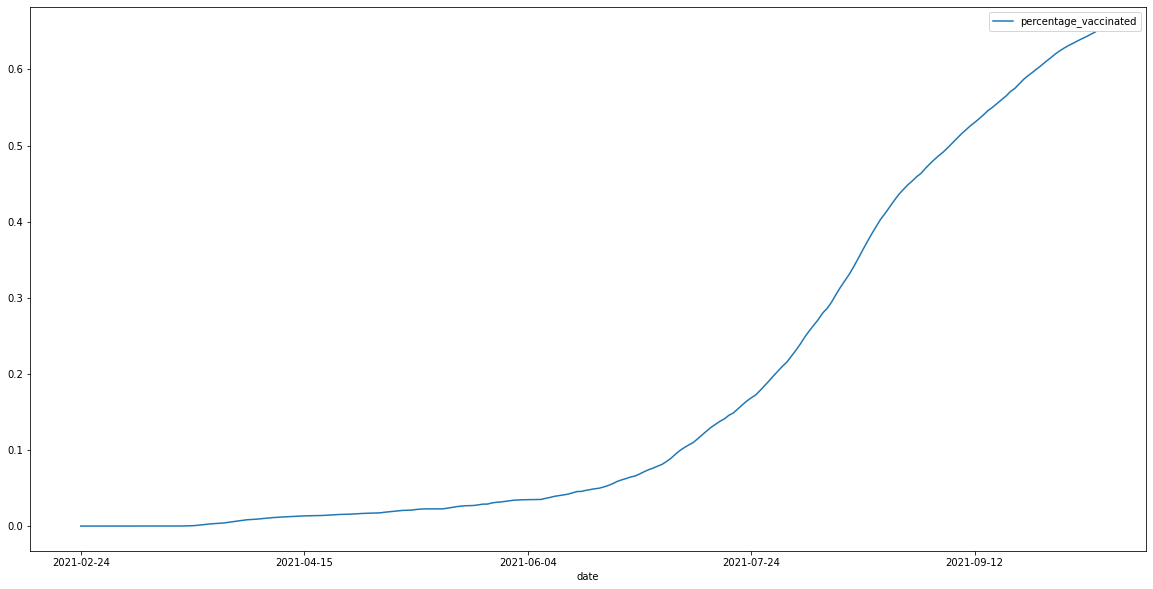

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
vax_malaysia.plot.line(x='date', y='percentage_vaccinated', figsize=(20,10))

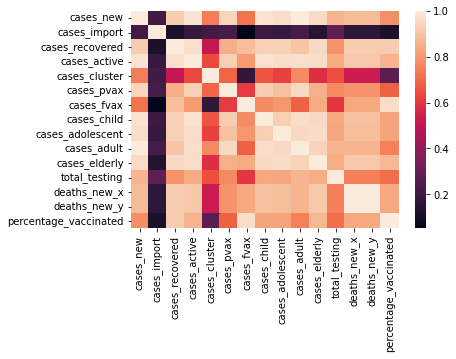

In [ ]:
cases_testing_deaths_vax = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(vax_malaysia[['date', 'percentage_vaccinated']], on='date')
sns.heatmap(cases_testing_deaths_vax.corr())

In [ ]:
!pip install boruta

     |████████████████████████████████| 56 kB 3.4 MB/s 


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

X = cases_testing_deaths_vax.drop(columns=['date','percentage_vaccinated'])
y = cases_testing_deaths_vax['percentage_vaccinated']

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
I

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1])

In [ ]:
accept = X.columns[feat_selector.support_].to_list()
X_filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
X_filtered

,cases_new,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,deaths_new_x,deaths_new_y
0,3545.0,3331.0,30572.0,2483.0,0.0,0.0,145.0,84.0,2919.0,173.0,12.0,12.0
1,1924.0,3752.0,28738.0,705.0,0.0,0.0,158.0,72.0,1473.0,155.0,13.0,13.0
2,2253.0,3085.0,27903.0,1136.0,0.0,0.0,124.0,75.0,1822.0,173.0,10.0,10.0
3,2364.0,3320.0,26937.0,1100.0,0.0,0.0,147.0,100.0,1858.0,162.0,10.0,10.0
4,2437.0,3251.0,26118.0,1404.0,0.0,0.0,132.0,83.0,2044.0,113.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,10915.0,15396.0,155499.0,656.0,1306.0,5885.0,1951.0,938.0,6756.0,1166.0,109.0,109.0
221,9066.0,14454.0,150019.0,388.0,1124.0,4944.0,1700.0,764.0,5348.0,1087.0,118.0,118.0
222,8075.0,15456.0,142562.0,731.0,1097.0,4287.0,1353.0,641.0,5050.0,948.0,76.0,76.0
223,8817.0,15615.0,135685.0,619.0,1062.0,5106.0,1386.0,686.0,5624.0,1007.0,117.0,117.0


In [ ]:
import tensorflow as tf

n_past = 10
n_future = 10
n_features = len(X_filtered.columns) + 1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_states1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

model_e1d1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10, 13)]          0         
_________________________________________________________________
lstm_16 (LSTM)               [(None, 100), (None, 100) 45600     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 10, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 10, 100)           80400     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 13)            1313      
Total params: 127,313
Trainable params: 127,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
num_rows = len(X_filtered)
top_75_per = int(0.75 * num_rows)
bottom_25_per = num_rows - top_75_per

X_train = X_filtered[1:top_75_per]

y_train = y[1:top_75_per]

X_test = X_filtered[top_75_per:]

y_test = y[top_75_per:]

In [ ]:
X_train

,cases_new,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,deaths_new_x,deaths_new_y
1,-0.901444,-0.662563,-0.861307,-0.748340,-1.000000,-1.000000,-0.953233,-0.963483,-0.891474,-0.854167,-0.933148,-0.933148
2,-0.868458,-0.745923,-0.869179,-0.447046,-1.000000,-1.000000,-0.978078,-0.959270,-0.841963,-0.827381,-0.949861,-0.949861
3,-0.857329,-0.716553,-0.878285,-0.472213,-1.000000,-1.000000,-0.961271,-0.924157,-0.836856,-0.843750,-0.949861,-0.949861
4,-0.850010,-0.725177,-0.886005,-0.259699,-1.000000,-1.000000,-0.972232,-0.948034,-0.810470,-0.916667,-0.955432,-0.955432
5,-0.911069,-0.820784,-0.892245,-0.568682,-1.000000,-1.000000,-0.972963,-0.987360,-0.896014,-0.933036,-0.977716,-0.977716
...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.000000,0.917390,0.915255,0.616218,1.000000,0.909516,0.983193,0.811798,1.000000,0.879464,-0.114206,-0.114206
164,0.836375,0.908392,0.939793,0.695911,0.834366,0.783671,0.823164,0.873596,0.787062,0.980655,0.164345,0.164345
165,0.779326,1.000000,0.952179,0.565886,0.721158,0.791992,0.839240,0.790730,0.751029,0.880952,1.000000,1.000000
166,0.633748,0.766544,0.968638,0.430968,0.603918,0.713989,0.658020,0.717697,0.573698,0.611607,0.175487,0.175487


In [ ]:
from sklearn.preprocessing import MinMaxScaler

train = X_train
scalers={}
for i in X_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = X_test
for i in X_test.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
y_train

1      0.000000e+00
2      3.062093e-08
3      6.124186e-08
4      1.531047e-07
5      2.755884e-07
           ...     
163    2.566082e-01
164    2.640961e-01
165    2.714011e-01
166    2.800161e-01
167    2.861460e-01
Name: percentage_vaccinated, Length: 167, dtype: float64

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
train['vac_percentage'] = y_train
test['vac_percentage'] = y_test
X_train, y_train = split_series(train.values, n_past, n_features)
train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

ValueError: ignored

## Has vaccination helped reduce the daily cases? What states have shown the effect of vaccination?

In [ ]:
### How well is Malaysia's vaccination campaign doing compared to other countries in Asia?